# Anomaly Detection with K-Means, Isolation Forest in Valeo

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score

# Libraries from Andrea Araldo
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram

from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector

# To show time at each cell
# Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
!pip install ipython-autotime 
%load_ext autotime

--2022-02-21 12:21:38--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   3.12K  --.-KB/s    in 0s      

2022-02-21 12:21:39 (40.1 MB/s) - ‘andrea_models.py’ saved [3190/3190]

--2022-02-21 12:21:39--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


time: 1.88 ms (started: 2022-02-21 12:21:55 +00:00)


In [2]:
np.random.seed(9)
random.seed(9) 

time: 1.73 ms (started: 2022-02-21 12:21:55 +00:00)


Import the Dataset

In [3]:
path = "https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned_exp.csv" # path for the preprocessed datadet
!wget $path

--2022-02-21 12:21:55--  https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned_exp.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3924758 (3.7M) [text/plain]
Saving to: ‘dataset_cleaned_exp.csv’

dataset_cleaned_exp 100%[===================>]   3.74M  --.-KB/s    in 0.09s   

2022-02-21 12:21:56 (41.2 MB/s) - ‘dataset_cleaned_exp.csv’ saved [3924758/3924758]

time: 944 ms (started: 2022-02-21 12:21:55 +00:00)


In [4]:
df = pd.read_csv("dataset_cleaned_exp.csv", index_col="PROC_TRACEINFO")
df.head()

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value_exp,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,results
PROC_TRACEINFO,,,,,,,,,,,,,,
I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,460468.625050,12.16,1,11.97,6.62,26.37,18.8,109.62,6.60,0
I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,498819.706587,12.19,0,11.97,6.41,21.03,18.5,105.48,6.40,0
I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,384615.725794,12.24,1,11.97,6.62,25.81,17.5,100.03,6.61,0
I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,369534.727474,12.35,0,11.97,6.62,24.62,15.6,104.94,6.61,0
I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,474491.982426,12.19,1,11.97,6.62,29.22,33.6,99.19,6.61,0


time: 220 ms (started: 2022-02-21 12:21:56 +00:00)


In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 34515 entries, I-B-XA1207672-190429-00688 to I-B-XA1207672-190712-03433
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   OP070_V_1_angle_value                34515 non-null  float64
 1   OP090_SnapRingPeakForce_value        34515 non-null  float64
 2   OP070_V_2_angle_value                34515 non-null  float64
 3   OP120_Rodage_I_mesure_value          34515 non-null  float64
 4   OP090_SnapRingFinalStroke_value_exp  34515 non-null  float64
 5   OP110_Vissage_M8_torque_value        34515 non-null  float64
 6   OP100_Capuchon_insertion_mesure      34515 non-null  int64  
 7   OP120_Rodage_U_mesure_value          34515 non-null  float64
 8   OP070_V_1_torque_value               34515 non-null  float64
 9   OP090_StartLinePeakForce_value       34515 non-null  float64
 10  OP110_Vissage_M8_angle_value         34515 non-null  

In [6]:
df['results'].value_counts()

0    34210
1      305
Name: results, dtype: int64

time: 6.4 ms (started: 2022-02-21 12:21:56 +00:00)


In [7]:
num_of_normal = sum( df['results']==0 )
num_of_anomalies = sum( df['results']==1 )
num_of_anomalies/num_of_normal

0.008915521777258111

time: 15.6 ms (started: 2022-02-21 12:21:56 +00:00)


Prepare a DataSet without the true label column for scaling

In [8]:
X = df.drop('results', axis=1)

time: 5.48 ms (started: 2022-02-21 12:21:56 +00:00)


In [9]:
y = [1 if c==1 else 0 for c in df['results']] 

time: 10.7 ms (started: 2022-02-21 12:21:56 +00:00)


Perform Standard Scaling

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

time: 18.4 ms (started: 2022-02-21 12:21:56 +00:00)


# K-means clustering

Try to find the good k value with the entire Dataset but wihtout the true label to find all the hyper parameters. Best number of k, how many cluster we want, what is the best number of initialization of centroids.

In [11]:
K =2
model = KMeans(n_clusters=K)
clusters = model.fit_predict(X_scaled)

time: 549 ms (started: 2022-02-21 12:21:57 +00:00)


In [12]:
clusters[0:5]

array([1, 0, 1, 1, 1], dtype=int32)

time: 6.67 ms (started: 2022-02-21 12:21:57 +00:00)


(array([10389.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 24126.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

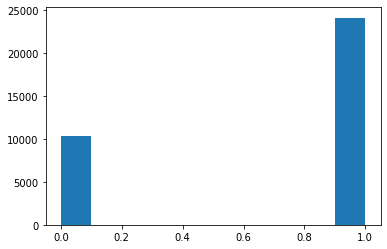

time: 212 ms (started: 2022-02-21 12:21:57 +00:00)


In [13]:
plt.hist(clusters)

In [14]:
model.inertia_

329383.6926139209

time: 5.39 ms (started: 2022-02-21 12:21:57 +00:00)


### Random initializations

In sklearn, Kmeans algorithm is repeated `n_init` times (by default 10), so to produce 10 models. The model with the smallest inertia is selected.

How to know if `n_init` is enough or we should increase it? Intuitively, the more the dimensions (features), the more random initializations we would need.

Suggestion: Repeat KMeans many times, increasing `n_init` until you see that the inertia stops improving.

To go fast, do this on a smaller subset.

In [15]:
n_samples = 10000
X_sub = subsample(X_scaled, n_samples)

time: 9.59 ms (started: 2022-02-21 12:21:57 +00:00)


Inertia with  10  initializations: 329383.6926139209
Inertia with  20  initializations: 329383.6885656074
Inertia with  30  initializations: 329383.6885656074
Inertia with  40  initializations: 329383.6885656074
Inertia with  50  initializations: 329383.6885656074
Inertia with  60  initializations: 329383.6885656074
Inertia with  70  initializations: 329383.6926139209
Inertia with  80  initializations: 329383.6885656074
Inertia with  90  initializations: 329383.6885656074
Inertia with  100  initializations: 329383.6885656074
Inertia with  110  initializations: 329383.6885656074
Inertia with  120  initializations: 329383.6885656074
Inertia with  130  initializations: 329383.6885656074
Inertia with  140  initializations: 329383.6885656074
Inertia with  150  initializations: 329383.6885656074
Inertia with  160  initializations: 329383.6959893452
Inertia with  170  initializations: 329383.6885656074
Inertia with  180  initializations: 329383.6926139209
Inertia with  190  initializations: 3

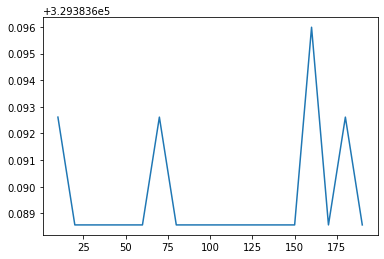

time: 1min 32s (started: 2022-02-21 12:21:57 +00:00)


In [16]:
inertia_values = []

repeats = range(10, 200, 10)

for r in repeats:
  model = KMeans(K, n_init=r)
  model.fit_predict(X_scaled)
  inertia_values.append(model.inertia_)
  print("Inertia with ", r, " initializations:", model.inertia_)

plt.plot(repeats, inertia_values)

In [17]:
n_init = 130

time: 1.42 ms (started: 2022-02-21 12:23:30 +00:00)


# Silhouette

First compute the distance between all the samples.

In [18]:
print("Distances to be computed: ", "{:e}".format( X_scaled.shape[0]**2) )

Distances to be computed:  1.191285e+09
time: 4.32 ms (started: 2022-02-21 12:23:30 +00:00)


In [19]:
model = KMeans(K, n_init=n_init)
clusters = model.fit_predict(X_scaled)

time: 4.58 s (started: 2022-02-21 12:23:30 +00:00)


In [20]:
silhouette_avg = silhouette_score(X_scaled, clusters)
silhouette_avg

0.27626429120604373

time: 12.6 s (started: 2022-02-21 12:23:35 +00:00)


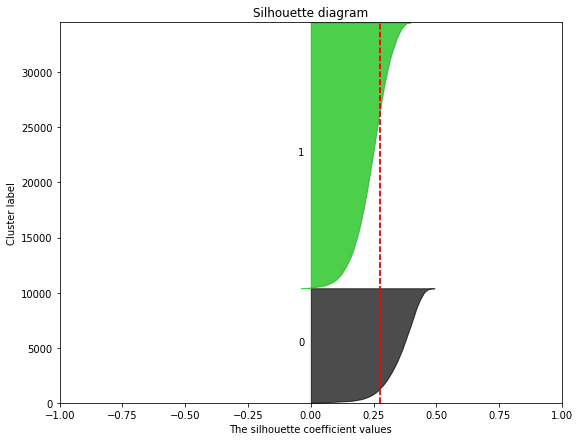

time: 24.9 s (started: 2022-02-21 12:23:48 +00:00)


In [21]:
sample_silhouette_values = silhouette_diagram(X_scaled, clusters, K)

For K= 2  the silhouette score is  0.27687822375496784
For K= 3  the silhouette score is  0.20048921901269534
For K= 4  the silhouette score is  0.2126640447107983
For K= 5  the silhouette score is  0.18060678700335878
For K= 6  the silhouette score is  0.17245588268046416
For K= 7  the silhouette score is  0.17125678849055181
For K= 8  the silhouette score is  0.16467384976867083
For K= 9  the silhouette score is  0.1471715388569731
For K= 10  the silhouette score is  0.13645916823378634
For K= 11  the silhouette score is  0.134855740937567


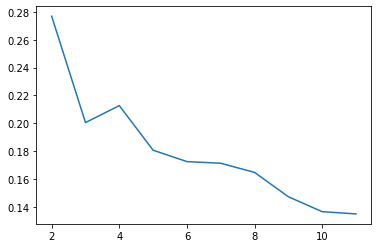

time: 2min 10s (started: 2022-02-21 12:24:13 +00:00)


In [22]:
max_clusters = 12

scores = []

for K in range (2,max_clusters):
  # To avoid using always the same seed, let's change the random state every time
  model = KMeans(K, n_init=n_init)
  clusters = model.fit_predict(X_sub)

  silhouette_avg = silhouette_score(X_sub, clusters)
  scores.append(silhouette_avg)
  print ("For K=",K, " the silhouette score is ", silhouette_avg)

plt.plot(range (2,max_clusters), scores)

In [23]:
K=2
n_init = 130

time: 1.34 ms (started: 2022-02-21 12:26:23 +00:00)


# Anomaly Detection

We are going to run KMeans with our hyperparameters K=4 and n_init=20

In [24]:
X_scaled, y = shuffle(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5)

time: 31.8 ms (started: 2022-02-21 12:26:35 +00:00)


In [31]:
model = KMeans(K, n_init=n_init)
clusters = model.fit_predict(X_train)

time: 2.63 s (started: 2022-02-21 12:29:17 +00:00)


In [32]:
model = KMeans(K, n_init=n_init)
model.fit(X_train)
y_pred = model.predict(X_test)

time: 7.53 s (started: 2022-02-21 12:30:28 +00:00)


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82     17113
           1       0.01      0.51      0.03       145

    accuracy                           0.70     17258
   macro avg       0.50      0.61      0.42     17258
weighted avg       0.99      0.70      0.82     17258

time: 57.7 ms (started: 2022-02-21 12:40:13 +00:00)


Normalized confusion matrix
[[0.70028633 0.29971367]
 [0.48965517 0.51034483]]


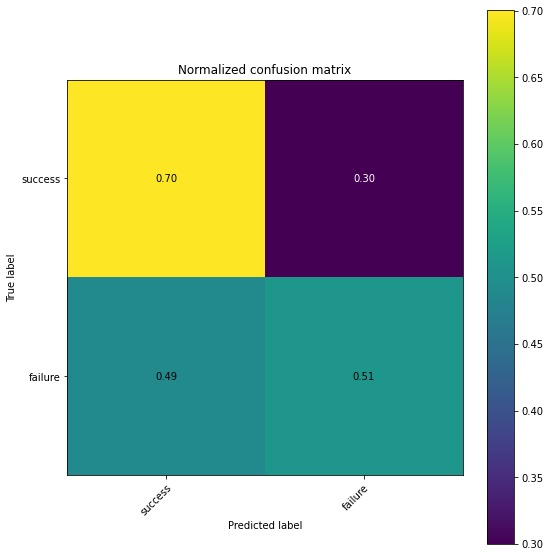

time: 658 ms (started: 2022-02-21 12:30:38 +00:00)


In [33]:
plot_conf_mat(y_test, y_pred, np.array(class_names))

In [25]:
model = KMeans(K, n_init=n_init)
clusters = model.fit_predict(X_scaled)

time: 12.3 s (started: 2022-02-21 12:26:46 +00:00)


Normalized confusion matrix
[[0.70078924 0.29921076]
 [0.49836066 0.50163934]]


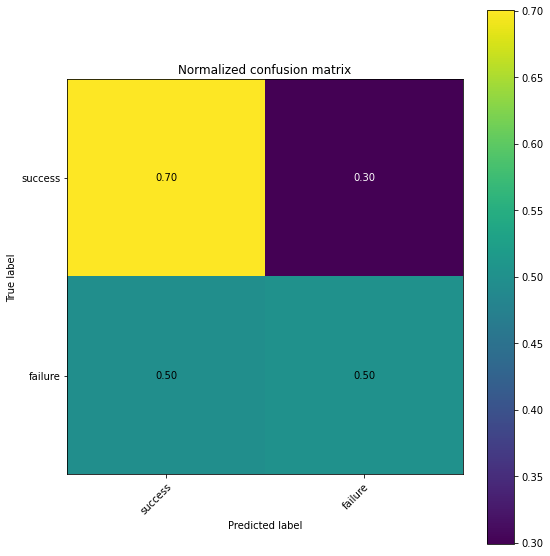

time: 521 ms (started: 2022-02-21 12:28:31 +00:00)


In [30]:
class_names = ["success", "failure"]
plot_conf_mat(y, clusters, np.array(class_names))

In [28]:
anomaly_scores = model.transform(X_train).min(axis=1)

time: 13.7 ms (started: 2022-02-21 12:27:16 +00:00)


In [26]:
anomaly_scores = model.transform(X_scaled).min(axis=1)

time: 14.1 ms (started: 2022-02-21 12:27:09 +00:00)


Text(0.5, 0, 'Recall')

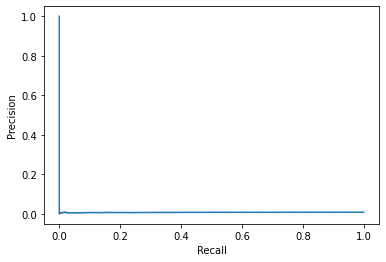

time: 512 ms (started: 2022-02-21 03:51:10 +00:00)


In [ ]:
precision, recall, thresholds = precision_recall_curve(y, anomaly_scores)
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_train, anomaly_scores)
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')